In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statsmodels.api as sm


# Add .. to the path
import sys
sys.path.append("..")

import src.utils as utils

plt.rcParams.update({"font.size": 9})
plt.rc("text", usetex=True)

<Axes: >

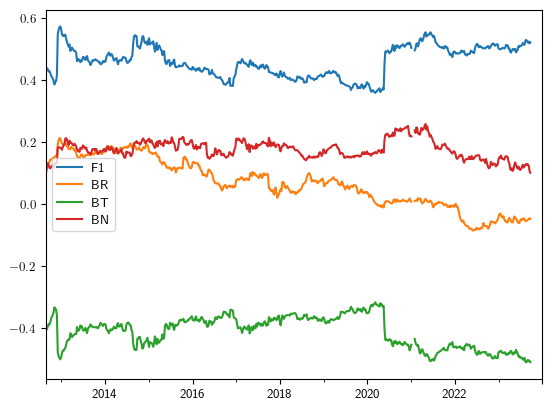

In [2]:
data_raw = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
data_raw.resample("7D").mean().plot()

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7461001 entries, 2012-08-25 00:00:00 to 2023-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F1      float32
 1   BR      float32
 2   BT      float32
 3   BN      float32
dtypes: float32(4)
memory usage: 170.8 MB


<Axes: >

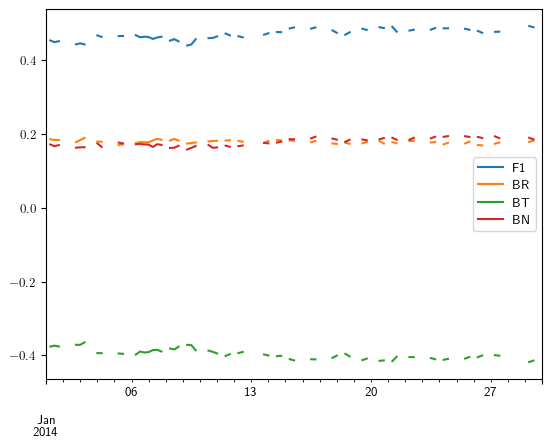

In [34]:
# First, convert DOY to date
doy_to_date = lambda year, doy: datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

# Extract interval I2

# data = data_raw[doy_to_date(2014, 184) : doy_to_date(2015, 131)]

# Extract different intervals
data = data_raw[doy_to_date(2014, 1) : doy_to_date(2014, 30)]

data.resample("6h").mean().plot()
#plt.title("Interval I2 from Fraternale et al. (2021)")

In [35]:
# Resample to 288s
#data = data.resample("288s").mean()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52201 entries, 2014-01-01 00:00:00 to 2014-01-30 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      11533 non-null  float32
 1   BR      11533 non-null  float32
 2   BT      11533 non-null  float32
 3   BN      11533 non-null  float32
dtypes: float32(4)
memory usage: 1.2 MB


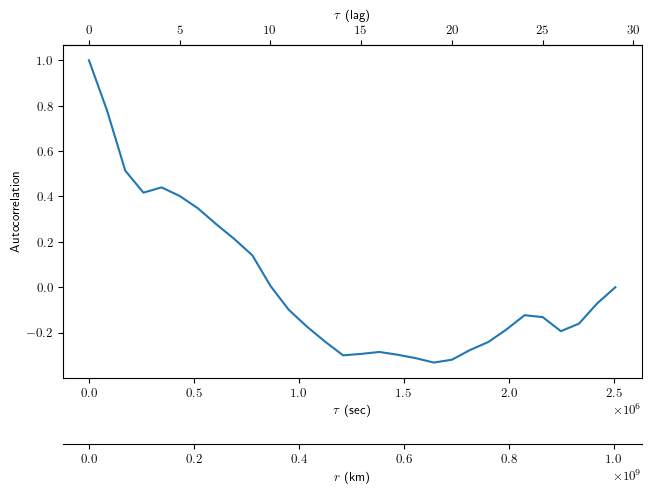

In [36]:
# Plot autocorrelation of F1 component

data_res = data.resample("1D").mean()

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [data_res.F1],
    nlags=len(data_res)-1,
    plot=True,
)

tce = 5.63 days


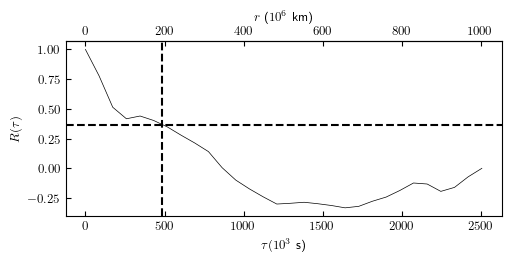

In [37]:
tce, fig, ax = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=True)
tce

# Convert tce from seconds to days
tce_days = tce / (24 * 3600)
print(f"tce = {tce_days:.2f} days")

In [38]:
tcf, fig, ax = utils.compute_outer_scale_exp_fit(
    time_lags=time_lags_lr,
    acf=r_vec_lr,
    seconds_to_fit=np.round(2 * tce),
    fig=fig,
    ax=ax,
    plot=True,
    initial_guess=tce
)

print(f"tcf = {tcf/ (24 * 3600):.2f} days")

tcf = 4.53 days


In [39]:
tci, fig, ax = utils.compute_outer_scale_integral(
    time_lags_lr, r_vec_lr, fig=fig, ax=ax, plot=True
)
print(f"tci = {tci/ (24 * 3600):.2f} days")

864000.0
tci = 4.53 days


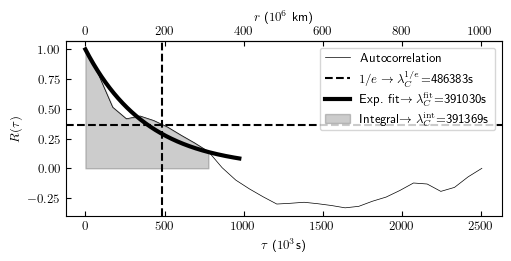

In [40]:
fig

**Correlation lengths from different length intervals of daily averages of F1:**

- 5-6 days for 1 month of data (only 30 points total)
- 9-10 days for 6 months of data
- 16-20 days for just under 1 year of data (int I1 from Fraternale 2021, in line with his results)
- 68-94 days for 2 years of data

In [41]:
data_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2014-01-01 to 2014-01-30
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      29 non-null     float32
 1   BR      29 non-null     float32
 2   BT      29 non-null     float32
 3   BN      29 non-null     float32
dtypes: float32(4)
memory usage: 720.0 bytes


In [42]:
# # Loop over the three estimator functions for different interval lengths and save the results in a dataframe

# int_lengths_days = [50, 100, 200, 400]
# tce_list = []
# tcf_list = []
# tci_list = []

# for int_length in int_lengths_days:
    
#     # Subset the data to the interval length
#     # Get the first int_length days of the data

#     # Convert interval length from days to pandas offset
#     int_length = f"{int_length}D"

#     time_lags_lr, r_vec_lr = utils.compute_nd_acf(
#         [data_res.F1],
#         nlags=len(data_res)-1,
#         plot=False,
#     )

#     tce = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)
#     tcf = utils.compute_outer_scale_exp_fit(
#         time_lags=time_lags_lr,
#         acf=r_vec_lr,
#         seconds_to_fit=np.round(2 * tce),
#         fig=None,
#         ax=None,
#         plot=False,
#         initial_guess=tce
#     )
#     tci = utils.compute_outer_scale_integral(
#         time_lags_lr, r_vec_lr, fig=None, ax=None, plot=False
#     )

#     tce_list.append(tce/ (24 * 3600))
#     tcf_list.append(tcf / (24 * 3600))
#     tci_list.append(tci / (24 * 3600))

# results = pd.DataFrame(
#     {
#         "Interval length [days]": int_lengths_days,
#         "tce [days]": tce_list,
#         "tcf [days]": tcf_list,
#         "tci [days]": tci_list
#     }
# )

In [43]:
results

NameError: name 'results' is not defined

## Taylor scale

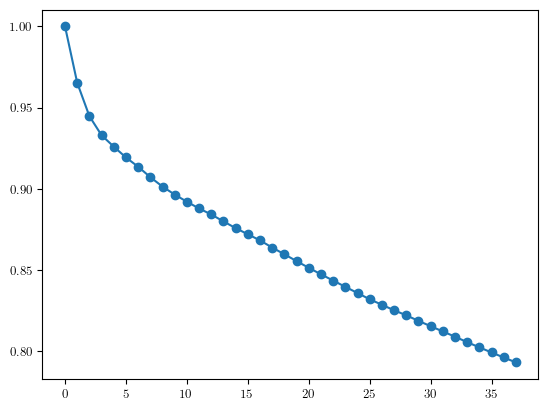

In [ ]:
acf = sm.tsa.acf(
    data["F1"], nlags=int(1800/ 48), missing="conservative"
)
plt.plot(acf, marker="o")

This one looks pretty damn similar to Fraternale's Fig 3a inset.